In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# 📊 CBIS-DDSM 乳房攝影分類專案報告（ResNet18）

## 🔖 描述
本專案使用 **CBIS-DDSM** 醫學影像資料集，透過 **ResNet18 預訓練模型**，進行乳房攝影影像的 **良性（Benign）與惡性（Malignant）腫瘤二分類**。

---

## 📌 內容
為了找出最佳的影像輸入策略，實驗比較三種不同的影像來源對分類效能的影響，包括：
- Full Mammogram（完整影像）
- Cropped Mammogram（病灶裁切影像）
- ROI Mask Image（病灶遮罩）

**此資料集為jpeg原始資料集（163GB）的格式。分辨率與原始資料集保持一致。**

* Number of Studies:6775
* Number of Series:6775
* Number of Participants:1,566（註）
* Number of Images:10239
* Modalities:MG
* Image Size (GB):6（.jpg）

**注意：此集合的圖像資料結構如下：每個參與者都有多個患者 ID。例如，pat_id 00038 有 10 個獨立的患者 ID，這些 ID 提供了 ID 內掃描的相關資訊（例如 Calc-Test_P_00038_LEFT_CC、Calc-Test_P_00038_RIGHT_CC_1）。根據 DICOM 元數據，這表示該隊列中有 6,671 名參與者，但實際參與者只有 1,566 名。**

---

## 🎯 專案目標
- 構建二分類模型以判斷腫瘤為良性或惡性  
- 探討三種影像輸入對分類準確率的影響  
- 透過統一架構比較模型表現，找出最佳輸入方式  

---

## 🗂️ 資料來源與處理

- **資料集**：CBIS-DDSM（Curated Breast Imaging Subset of DDSM）  
- **影像來源類型**：
  - `image file path`：完整乳房影像（Full）
  - `cropped image file path`：病灶局部裁切影像（Cropped）
  - `ROI mask file path`：病灶遮罩（ROI）

- **標籤處理**：
  - `BENIGN`, `BENIGN_WITHOUT_CALLBACK` → `0`  
  - `MALIGNANT` → `1`

- **影像前處理**：
  - 尺寸統一為 `224x224`
  - 使用 ImageNet 標準均值與標準差進行正規化  
  - Cropped 與 ROI 圖像可互換作為輸入來源

---

## 🧠 模型架構與訓練設定

- **模型**：ResNet18（使用 ImageNet 預訓練權重）  
- **輸出層**：將 `fc` 層替換為 2 類輸出 (`nn.Linear(..., 2)`)  
- **損失函數**：CrossEntropyLoss  
- **優化器**：Adam（學習率 1e-4）  
- **訓練設定**：
  - Epochs：20  
  - Batch size：16  
  - 切分比例：80% 訓練 / 20% 測試（stratified）

---

## 📈 評估指標

- **準確率（Accuracy）**  
- **分類報告**（Precision、Recall、F1-score）  
- **混淆矩陣（Confusion Matrix）**

透過 `sklearn.metrics` 評估模型預測效能，並以混淆矩陣視覺化誤判情況。

---

## ✅ 實驗內容概要

- 使用相同 ResNet18 架構與訓練流程，分別測試以下輸入方式：
  1. Full Mammogram
  2. Cropped Mammogram
  3. ROI Mask Image
- 比較各種輸入對模型在測試集上的分類效果
- 記錄每一種輸入所對應的 Accuracy、F1-score 與錯誤預測樣本
- 分析哪種輸入策略能更有效幫助模型識別惡性腫瘤（提升 Recall）


In [50]:
df_meta= pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
print(df_meta.info())
print("\n" + "-"*50 + "\n")
df_meta.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  6775 non-null   object
 1   StudyInstanceUID   6775 non-null   object
 2   Modality           6775 non-null   object
 3   SeriesDescription  6775 non-null   object
 4   BodyPartExamined   6775 non-null   object
 5   SeriesNumber       6775 non-null   int64 
 6   Collection         6775 non-null   object
 7   Visibility         6775 non-null   int64 
 8   ImageCount         6775 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 476.5+ KB
None

--------------------------------------------------



SeriesInstanceUID  \
0  1.3.6.1.4.1.9590.100.1.2.117041576511324414842...   
1  1.3.6.1.4.1.9590.100.1.2.438738396107617880132...   
2  1.3.6.1.4.1.9590.100.1.2.767416741131676463382...   

                                    StudyInstanceUID Modality  \
0  1.3.6.1.4.1.9590.100.1.2.229361142710768138411...       MG   
1  1.3.6.1.4.1.9590.100.1.2.195593486612988388325...       MG   
2  1.3.6.1.4.1.9590.100.1.2.257901172612530623323...       MG   

  SeriesDescription BodyPartExamined  SeriesNumber Collection  Visibility  \
0   ROI mask images           BREAST             1  CBIS-DDSM           1   
1   ROI mask images           BREAST             1  CBIS-DDSM           1   
2   ROI mask images           BREAST             1  CBIS-DDSM           1   

   ImageCount  
0           2  
1           2  
2           2

* 📁 DICOM 與一般圖片的差異
* 格式	用途	影像 + 標註資訊	支援多張影像	常見副檔名
* DICOM	醫學影像專用格式	✅ 是（很詳細）	✅ 支援	.dcm
* PNG / JPEG	一般圖片格式	❌ 無	❌	.png, .jpg

In [11]:
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
print(df_dicom.info())
print("\n" + "-"*50 + "\n")
df_dicom.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   

   BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0             16          16           BREAST      351     20160426   
1             16          16           BREAST     3526     20160426   
2             16          16           BREAST     1546     20160503   

   ContentTime ConversionType  ...  \
0   131732.685            WSD  ...   
1   143829.101            WSD  ...   
2   111956.298            WSD  ...   

   SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                       MATLAB         cropped images   
1                                       MATLAB  full mammogram images   
2                                       MATLAB  full mammogram images   

                                   SeriesInstanceUID SeriesNumber  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...            1   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...            1   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...            1   

  SmallestImagePixelValue  SpecificCharacterSet   StudyDate StudyID  \
0                   23078            ISO_IR 100  20160720.0    DDSM   
1                       0            ISO_IR 100  20160720.0    DDSM   
2                       0            ISO_IR 100  20160807.0    DDSM   

                                    StudyInstanceUID  StudyTime  
0  1.3.6.1.4.1.9590.100.1.2.271867287611061855725...   214951.0  
1  1.3.6.1.4.1.9590.100.1.2.161516517311681906612...   193426.0  
2  1.3.6.1.4.1.9590.100.1.2.291043622711253836701...   161814.0  

[3 rows x 38 columns]

前處理
1. 部分缺失欄位 : 時間、描述(StudyDate、StudyTime)
2. 全部缺失欄位 : 性別、號碼類(AccessionNumber、PatientBirthDate、PatientSex、ReferringPhysicianName)

> bfill 、 drop

In [12]:
#df_dicom.isna().sum() 
df_dicom.isna().sum()[df_dicom.isna().sum() > 0].sort_values()

Laterality                  566
SeriesDescription           566
StudyDate                   566
StudyTime                   566
AccessionNumber           10237
PatientBirthDate          10237
PatientSex                10237
ReferringPhysicianName    10237
dtype: int64

In [13]:
df_dicom["Laterality"].unique()

array(['R', 'L', nan], dtype=object)

In [14]:
drop_columns = [
    'AccessionNumber', 
    'PatientBirthDate', 
    'PatientSex', 
    'ReferringPhysicianName',
    'StudyDate', 
    'StudyTime'
]
df_dicom.drop(columns=drop_columns, inplace=True)


In [15]:
df_dicom['Laterality'] = df_dicom['Laterality'] .fillna('Front')
df_dicom['Laterality'].unique()

array(['R', 'L', 'Front'], dtype=object)

In [16]:
#assert df_dicom.isna().sum().sum()==0

In [17]:
df_dicom['SeriesDescription'].unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

# 前處理-路徑
> 用字典做映照dict[key]=value

In [18]:
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path

cropped_images[0]

'CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg'

In [19]:
#imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'
imdir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammos = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_imgs = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

cropped_images.iloc[0]

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg'

In [20]:
dic_cropped_images = dict()
dic_full_mammos = dict()
dic_roi_imgs = dict()

for cropped_image in cropped_images:
    key = cropped_image.split("/")[5]
    value = cropped_image
    dic_cropped_images[key] = value
for full_mammo in full_mammos:
    key = full_mammo.split("/")[5]
    value = full_mammo
    dic_full_mammos[key] = value
for roi_img in roi_imgs:
    key = roi_img.split("/")[5]
    value = roi_img
    dic_roi_imgs[key] = value

dic_cropped_images['1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304']

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg'

# 前處理-Mass Dataset

In [21]:
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

print(mass_train.info())
print("\n" + "-"*50 + "\n")
mass_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   

  abnormality type                          mass shape mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION  ILL_DEFINED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   

                                     image file path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped image file path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI mask file path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...

In [22]:
mass_train['image file path'][0].split("/")

['Mass-Training_P_00001_LEFT_CC',
 '1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994',
 '1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515',
 '000000.dcm']

> image file path內切完後的第2個才是key ->第1個映射不到

In [23]:
#dic_full_mammos['1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994']
dic_full_mammos['1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515']

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg'

In [24]:
def fix_path(dataset):
    for idx in range(len(dataset)):
        #dic_full_mammos
        old_key = dataset['image file path'][idx].split("/")[2]
        dataset['image file path'][idx] = dic_full_mammos[old_key]
        #dic_cropped_images
        old_key = dataset['cropped image file path'][idx].split("/")[2]
        dataset['cropped image file path'][idx] = dic_cropped_images[old_key]
        #dic_roi_imgs
        old_key = dataset['ROI mask file path'][idx].split("/")[2]
        dataset['ROI mask file path'][idx] = dic_roi_imgs[old_key]

In [25]:
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

fix_path(mass_train)
fix_path(mass_test)

/tmp/ipykernel_36/3047282551.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['image file path'][idx] = dic_full_mammos[old_key]
/tmp/ipykernel_36/3047282551.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [26]:
#測試是否改path
assert mass_test['ROI mask file path'][0].split("/")[1]=='kaggle',"Fail_rename_path error"

* BENIGN -> 良性
* MALIGNANT -> 惡性

In [27]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

NA: -> bfill
* mass shape
* mass margins  

In [28]:
print(mass_train.isnull().sum())
print("\n" + "-"*50 + "\n")
print(mass_test.isnull().sum())

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

--------------------------------------------------

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64


In [29]:
mass_train['mass shape'] = mass_train['mass shape'].fillna('bfill')
mass_train['mass margins'] = mass_train['mass margins'].fillna('bfill')
mass_test['mass shape'] = mass_test['mass shape'].fillna('bfill')
mass_test['mass margins'] = mass_test['mass margins'].fillna('bfill')

assert mass_train.isnull().sum().sum()==0,"bfill train error"
assert mass_test.isnull().sum().sum()==0,"bfill test error"

In [30]:
mass_train.describe()

breast_density  abnormality id   assessment     subtlety
count     1318.000000     1318.000000  1318.000000  1318.000000
mean         2.203338        1.116085     3.504552     3.965857
std          0.873774        0.467013     1.414609     1.102032
min          1.000000        1.000000     0.000000     0.000000
25%          2.000000        1.000000     3.000000     3.000000
50%          2.000000        1.000000     4.000000     4.000000
75%          3.000000        1.000000     4.000000     5.000000
max          4.000000        6.000000     5.000000     5.000000

In [31]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


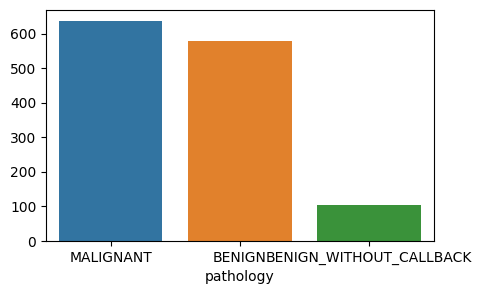

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
value = mass_train['pathology'].value_counts()
plt.figure(figsize=(5,3))

sns.barplot(x=value.index, y=value.values)
plt.show()

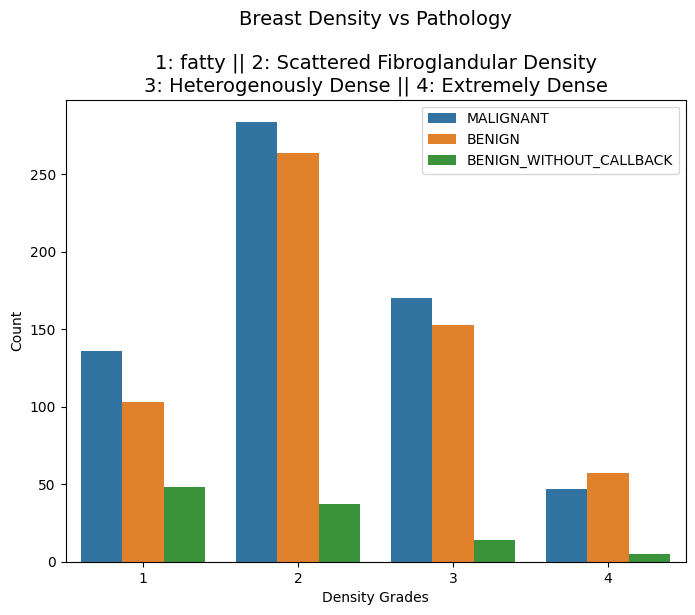

In [33]:
# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(mass_train, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()
plt.savefig('/kaggle/working/density_pathology_red.png')
plt.show()

Full Mammograms:



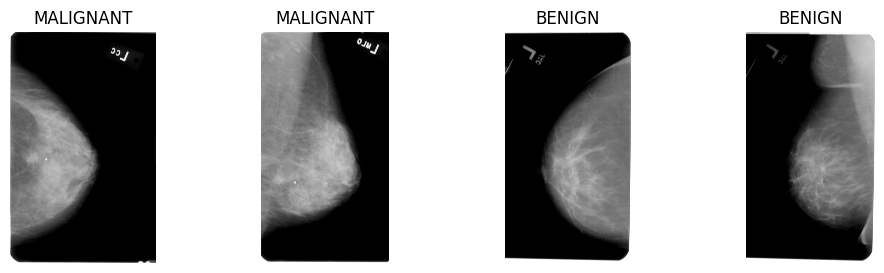

Cropped Mammograms:



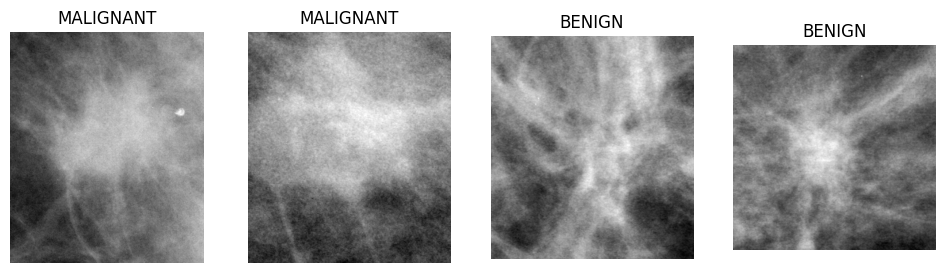

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def show_images(df, path_col, n=5, title_col="pathology"):
    """
    顯示前 n 張影像。

    :param df:        資料表 (pandas.DataFrame)
    :param path_col:  影像檔路徑欄位名稱
    :param n:         要顯示的張數，預設 5
    :param title_col: 子標題欄位名稱，預設 "pathology"
    """
    subset = df.head(n)
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))

    for ax, (_, row) in zip(axes, subset.iterrows()):
        ax.imshow(mpimg.imread(row[path_col]), cmap="gray")
        ax.set_title(row[title_col])
        ax.axis("off")

    plt.show()


print(f"Full Mammograms:\n")
show_images(mass_train, "image file path", n=4)

print(f"Cropped Mammograms:\n")
show_images(mass_train, "cropped image file path", n=4)

print(f"ROI mask images:\n")
show_images(mass_train, "ROI mask images", n=4)


# 1. Full Mammograms 良性／惡性二分類

In [35]:
# ============================================================================
# 0. 套件 import
# ============================================================================
import os, cv2, numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
# 若需模型摘要，可安裝 `pip install torchsummary`
from torchsummary import summary  

# ============================================================================
# 1. 影像前處理函式 ── 等同 image_processor()
# ============================================================================
def load_and_resize(path: str, size: tuple[int, int]) -> np.ndarray:
    """BGR→RGB、resize、歸一化到 [0,1]"""
    img = cv2.imread(os.path.abspath(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img.astype(np.float32) / 255.0               # HWC

# ============================================================================
# 2. 併資料表、產生標籤
# ============================================================================
full_mass = pd.concat([mass_train, mass_test], axis=0).reset_index(drop=True)
CLASS_MAPPER = {"MALIGNANT": 1, "BENIGN": 0, "BENIGN_WITHOUT_CALLBACK": 0}
full_mass["label"] = full_mass["pathology"].replace(CLASS_MAPPER)

# 先把影像全部 load 到記憶體（若資料量大可改 lazy-load）
TARGET_HW = (224, 224)
full_mass["image_arr"] = full_mass["image file path"].apply(
    lambda p: load_and_resize(p, TARGET_HW)
)
X = np.stack(full_mass["image_arr"].to_numpy())          # (N, 224, 224, 3)
y = full_mass["label"].to_numpy().astype(np.int64)       # (N,)

# ============================================================================
# 3. 切 train / val / test = 70 : 10 : 20
# ============================================================================
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_te, y_val, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.33, random_state=42, stratify=y_tmp
)

# ============================================================================
# 4. Dataset 
# ============================================================================
class MassDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.tf =  transform or transforms.ToTensor()

    def __len__(self):  
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = self.tf(img)                                # → Tensor(CHW)
        return img, torch.tensor(self.labels[idx])

/tmp/ipykernel_36/1755035154.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_mass["label"] = full_mass["pathology"].replace(CLASS_MAPPER)


## CNN train from scratch

> 資料增強:transform

In [60]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
eval_transform  = transforms.Compose([transforms.ToPILImage(),
                               transforms.Resize((224, 224)),
                               transforms.ToTensor()])

In [61]:
train_ds = MassDataset(X_tr,  y_tr,  train_transform)
val_ds   = MassDataset(X_val, y_val, eval_transform)
test_ds  = MassDataset(X_te,  y_te,  eval_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=4)

In [62]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,   32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,  64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,  64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),                      # 128×7×7
            nn.Linear(128*7*7, 512), nn.ReLU(),
            nn.Linear(512, 2)                 # 兩類；CrossEntropyLoss 內含 softmax
        )
    def forward(self, x):
        return self.net(x)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = SimpleCNN().to(device)
summary(model, input_size=(3, 224, 224))                 # 類似 model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,928
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 128, 14, 14]         147,584
             ReLU-14          [-1, 128,

In [64]:
# ============================================================================
# 6. 優化器、損失函數、訓練 / 驗證迴圈
# ============================================================================
criterion = nn.CrossEntropyLoss()                         # = TF 的 binary_crossentropy + softmax
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 20

for epoch in range(EPOCHS):
    # ---- train ----
    model.train()
    tr_loss, tr_correct = 0.0, 0
    for x, yb in train_loader:
        x, yb = x.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()

        tr_loss += loss.item() * x.size(0)
        tr_correct += (out.argmax(1) == yb).sum().item()

    # ---- val ----
    model.eval()
    va_loss, va_correct = 0.0, 0
    with torch.no_grad():
        for x, yb in val_loader:
            x, yb = x.to(device), yb.to(device)
            out = model(x)
            va_loss += criterion(out, yb).item() * x.size(0)
            va_correct += (out.argmax(1) == yb).sum().item()

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss {tr_loss/len(train_ds):.4f} Acc {tr_correct/len(train_ds):.4f} | "
          f"Val Loss {va_loss/len(val_ds):.4f} Acc {va_correct/len(val_ds):.4f}")

Epoch 01/20 | Train Loss 0.6918 Acc 0.5215 | Val Loss 0.6899 Acc 0.5396
Epoch 02/20 | Train Loss 0.6915 Acc 0.5375 | Val Loss 0.6898 Acc 0.5396
Epoch 03/20 | Train Loss 0.6907 Acc 0.5375 | Val Loss 0.6899 Acc 0.5396
Epoch 04/20 | Train Loss 0.6897 Acc 0.5341 | Val Loss 0.6880 Acc 0.5396
Epoch 05/20 | Train Loss 0.6896 Acc 0.5274 | Val Loss 0.6877 Acc 0.5455
Epoch 06/20 | Train Loss 0.6870 Acc 0.5434 | Val Loss 0.7004 Acc 0.4985
Epoch 07/20 | Train Loss 0.6874 Acc 0.5560 | Val Loss 0.6842 Acc 0.5484
Epoch 08/20 | Train Loss 0.6777 Acc 0.5754 | Val Loss 0.6808 Acc 0.5630
Epoch 09/20 | Train Loss 0.6759 Acc 0.5737 | Val Loss 0.6782 Acc 0.5572
Epoch 10/20 | Train Loss 0.6725 Acc 0.5779 | Val Loss 0.6809 Acc 0.5455
Epoch 11/20 | Train Loss 0.6706 Acc 0.5788 | Val Loss 0.6730 Acc 0.5630
Epoch 12/20 | Train Loss 0.6693 Acc 0.5864 | Val Loss 0.6720 Acc 0.5777
Epoch 13/20 | Train Loss 0.6692 Acc 0.5754 | Val Loss 0.6675 Acc 0.5777
Epoch 14/20 | Train Loss 0.6726 Acc 0.5611 | Val Loss 0.6651 Acc

In [65]:
# ============================================================================
# 7. 測試集評估（可選）
# ============================================================================
model.eval()
test_correct = 0
with torch.no_grad():
    for x, yb in test_loader:
        x, yb = x.to(device), yb.to(device)
        test_correct += (model(x).argmax(1) == yb).sum().item()
print(f"Test Accuracy: {test_correct / len(test_ds):.4f}")

Test Accuracy: 0.5357


## -----Confusion Matrix 1.1

### Train : 0.6099
### Valid : 0.6070
### Test  : 0.5357

## Resnet-18 Pretrained w/Freeze 
> 
> Only_train_Fc_Layer
> 

In [37]:
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import torch

# ---------- 1. transforms ----------
tf_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
tf_eval = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_ds = MassDataset(X_tr,  y_tr,  tf_train)
val_ds   = MassDataset(X_val, y_val, tf_eval)
test_ds  = MassDataset(X_te,  y_te,  tf_eval)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=4)

In [39]:
#Resnet-18:


# ---------- 2. model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in model.parameters():          # 先凍結
    p.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)  # 兩類
model = model.to(device)

# 只訓練最後一層參數
optimizer = torch.optim.Adam(model.fc.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()  # 或加 class_weight
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ---------- 3. training loop ----------
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    tr_loss = tr_correct = 0
    for x, yb in train_loader:
        x, yb = x.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()

        tr_loss += loss.item() * x.size(0)
        tr_correct += (out.argmax(1) == yb).sum().item()

    model.eval()
    va_loss = va_correct = 0
    with torch.no_grad():
        for x, yb in val_loader:
            x, yb = x.to(device), yb.to(device)
            out = model(x)
            va_loss += criterion(out, yb).item() * x.size(0)
            va_correct += (out.argmax(1) == yb).sum().item()

    scheduler.step()   # 調降學習率

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss {tr_loss/len(train_ds):.4f} Acc {tr_correct/len(train_ds):.4f} | "
          f"Val Loss {va_loss/len(val_ds):.4f} Acc {va_correct/len(val_ds):.4f}")


Epoch 01/20 | Train Loss 0.7165 Acc 0.5324 | Val Loss 0.7044 Acc 0.5337
Epoch 02/20 | Train Loss 0.6766 Acc 0.5796 | Val Loss 0.6733 Acc 0.5982
Epoch 03/20 | Train Loss 0.6748 Acc 0.5821 | Val Loss 0.6653 Acc 0.6012
Epoch 04/20 | Train Loss 0.6648 Acc 0.5897 | Val Loss 0.6420 Acc 0.6393
Epoch 05/20 | Train Loss 0.6483 Acc 0.5998 | Val Loss 0.6370 Acc 0.6510
Epoch 06/20 | Train Loss 0.6389 Acc 0.6259 | Val Loss 0.6338 Acc 0.6481
Epoch 07/20 | Train Loss 0.6293 Acc 0.6420 | Val Loss 0.6321 Acc 0.6452
Epoch 08/20 | Train Loss 0.6236 Acc 0.6605 | Val Loss 0.6312 Acc 0.6628
Epoch 09/20 | Train Loss 0.6243 Acc 0.6445 | Val Loss 0.6320 Acc 0.6569
Epoch 10/20 | Train Loss 0.6307 Acc 0.6335 | Val Loss 0.6330 Acc 0.6657
Epoch 11/20 | Train Loss 0.6289 Acc 0.6639 | Val Loss 0.6309 Acc 0.6569
Epoch 12/20 | Train Loss 0.6287 Acc 0.6436 | Val Loss 0.6327 Acc 0.6657
Epoch 13/20 | Train Loss 0.6227 Acc 0.6596 | Val Loss 0.6345 Acc 0.6628
Epoch 14/20 | Train Loss 0.6280 Acc 0.6554 | Val Loss 0.6308 Acc

In [40]:
import torch
from tqdm import tqdm   # 讓迴圈有進度條，非必要可拿掉

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Inference"):
        imgs  = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)           # 取 logits 最大值的類別

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# 轉成一維 tensor
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


Inference: 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


## -----Confusion Matrix 1.2


### Train : 0.6320
### Valid : 0.6686
### Test  : 0.

In [41]:
from sklearn.metrics import classification_report

target_names = ["BENIGN", "MALIGNANT"]
report = classification_report(all_labels, all_preds,
                               target_names=target_names,
                               digits=4)     # 顯示四位小數
print(report)


              precision    recall  f1-score   support

      BENIGN     0.6413    0.6556    0.6484        90
   MALIGNANT     0.5921    0.5769    0.5844        78

    accuracy                         0.6190       168
   macro avg     0.6167    0.6162    0.6164       168
weighted avg     0.6185    0.6190    0.6187       168



## Resnet-18 Pretrained w/o Freeze

In [42]:
#Resnet-18:


# ---------- 2. model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)  # 兩類
model = model.to(device)

# 只訓練最後一層參數
optimizer = torch.optim.Adam(model.fc.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()  # 或加 class_weight
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ---------- 3. training loop ----------
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    tr_loss = tr_correct = 0
    for x, yb in train_loader:
        x, yb = x.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()

        tr_loss += loss.item() * x.size(0)
        tr_correct += (out.argmax(1) == yb).sum().item()

    model.eval()
    va_loss = va_correct = 0
    with torch.no_grad():
        for x, yb in val_loader:
            x, yb = x.to(device), yb.to(device)
            out = model(x)
            va_loss += criterion(out, yb).item() * x.size(0)
            va_correct += (out.argmax(1) == yb).sum().item()

    scheduler.step()   # 調降學習率

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss {tr_loss/len(train_ds):.4f} Acc {tr_correct/len(train_ds):.4f} | "
          f"Val Loss {va_loss/len(val_ds):.4f} Acc {va_correct/len(val_ds):.4f}")


Epoch 01/20 | Train Loss 0.7172 Acc 0.5004 | Val Loss 0.6852 Acc 0.5748
Epoch 02/20 | Train Loss 0.6808 Acc 0.5771 | Val Loss 0.6557 Acc 0.6100
Epoch 03/20 | Train Loss 0.6564 Acc 0.6116 | Val Loss 0.6612 Acc 0.5953
Epoch 04/20 | Train Loss 0.6609 Acc 0.6024 | Val Loss 0.6393 Acc 0.6334
Epoch 05/20 | Train Loss 0.6330 Acc 0.6546 | Val Loss 0.6345 Acc 0.6481
Epoch 06/20 | Train Loss 0.6275 Acc 0.6639 | Val Loss 0.6272 Acc 0.6628
Epoch 07/20 | Train Loss 0.6285 Acc 0.6605 | Val Loss 0.6263 Acc 0.6745
Epoch 08/20 | Train Loss 0.6373 Acc 0.6495 | Val Loss 0.6262 Acc 0.6598
Epoch 09/20 | Train Loss 0.6326 Acc 0.6487 | Val Loss 0.6236 Acc 0.6686
Epoch 10/20 | Train Loss 0.6227 Acc 0.6664 | Val Loss 0.6231 Acc 0.6628
Epoch 11/20 | Train Loss 0.6330 Acc 0.6504 | Val Loss 0.6231 Acc 0.6657
Epoch 12/20 | Train Loss 0.6313 Acc 0.6740 | Val Loss 0.6210 Acc 0.6598
Epoch 13/20 | Train Loss 0.6350 Acc 0.6479 | Val Loss 0.6248 Acc 0.6540
Epoch 14/20 | Train Loss 0.6273 Acc 0.6487 | Val Loss 0.6228 Acc

In [45]:
import torch
from tqdm import tqdm   # 讓迴圈有進度條，非必要可拿掉

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

all_preds, all_labels = [], []
test_correct = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Inference"):
        imgs  = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)           # 取 logits 最大值的類別

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        
        test_correct += (model(imgs).argmax(1) == labels).sum().item()

# 轉成一維 tensor
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print(f"Test Accuracy: {test_correct / len(test_ds):.4f}")

Inference: 100%|██████████| 11/11 [00:15<00:00,  1.37s/it]

Test Accuracy: 0.6369


## -----Confusion Matrix 1.3


### Train : 0.6320

### Valid : 0.6686

### Test  : 0.6369

In [44]:
from sklearn.metrics import classification_report

target_names = ["BENIGN", "MALIGNANT"]
report = classification_report(all_labels, all_preds,
                               target_names=target_names,
                               digits=4)     # 顯示四位小數
print(report)


              precision    recall  f1-score   support

      BENIGN     0.6559    0.6778    0.6667        90
   MALIGNANT     0.6133    0.5897    0.6013        78

    accuracy                         0.6369       168
   macro avg     0.6346    0.6338    0.6340       168
weighted avg     0.6361    0.6369    0.6363       168



# 2.Cropped Mammograms 良性／惡性二分類

## Resnet-18 Pretrained w/o Freeze _

In [48]:
# ---------- 1. transforms ----------
tf_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
tf_eval = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
cropped_mass = pd.concat([mass_train, mass_test], axis=0).reset_index(drop=True)
CLASS_MAPPER = {"MALIGNANT": 1, "BENIGN": 0, "BENIGN_WITHOUT_CALLBACK": 0}
cropped_mass["label"] = cropped_mass["pathology"].replace(CLASS_MAPPER)

# 先把影像全部 load 到記憶體（若資料量大可改 lazy-load）
TARGET_HW = (224, 224)
cropped_mass["image_arr"] = cropped_mass["cropped image file path"].apply(
    lambda p: load_and_resize(p, TARGET_HW)
)
# Xy
X = np.stack(cropped_mass["image_arr"].to_numpy())          # (N, 224, 224, 3)
y = cropped_mass["label"].to_numpy().astype(np.int64)       # (N,)
#切721
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_te, y_val, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.33, random_state=42, stratify=y_tmp
)

train_ds = MassDataset(X_tr,  y_tr,  tf_train)
val_ds   = MassDataset(X_val, y_val, tf_eval)
test_ds  = MassDataset(X_te,  y_te,  tf_eval)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=4)

/tmp/ipykernel_36/346460805.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cropped_mass["label"] = cropped_mass["pathology"].replace(CLASS_MAPPER)


In [49]:
#Resnet-18:


# ---------- 2. model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)  # 兩類
model = model.to(device)

# 只訓練最後一層參數
optimizer = torch.optim.Adam(model.fc.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()  # 或加 class_weight
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ---------- 3. training loop ----------
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    tr_loss = tr_correct = 0
    for x, yb in train_loader:
        x, yb = x.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()

        tr_loss += loss.item() * x.size(0)
        tr_correct += (out.argmax(1) == yb).sum().item()

    model.eval()
    va_loss = va_correct = 0
    with torch.no_grad():
        for x, yb in val_loader:
            x, yb = x.to(device), yb.to(device)
            out = model(x)
            va_loss += criterion(out, yb).item() * x.size(0)
            va_correct += (out.argmax(1) == yb).sum().item()

    scheduler.step()   # 調降學習率

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss {tr_loss/len(train_ds):.4f} Acc {tr_correct/len(train_ds):.4f} | "
          f"Val Loss {va_loss/len(val_ds):.4f} Acc {va_correct/len(val_ds):.4f}")


Epoch 01/20 | Train Loss 0.6924 Acc 0.5678 | Val Loss 0.6762 Acc 0.5660
Epoch 02/20 | Train Loss 0.6544 Acc 0.6184 | Val Loss 0.6506 Acc 0.6129
Epoch 03/20 | Train Loss 0.6454 Acc 0.6318 | Val Loss 0.6419 Acc 0.6217
Epoch 04/20 | Train Loss 0.6359 Acc 0.6369 | Val Loss 0.6478 Acc 0.6158
Epoch 05/20 | Train Loss 0.6161 Acc 0.6655 | Val Loss 0.6570 Acc 0.6246
Epoch 06/20 | Train Loss 0.6374 Acc 0.6335 | Val Loss 0.6262 Acc 0.6481
Epoch 07/20 | Train Loss 0.6116 Acc 0.6807 | Val Loss 0.6242 Acc 0.6510
Epoch 08/20 | Train Loss 0.6037 Acc 0.6891 | Val Loss 0.6214 Acc 0.6540
Epoch 09/20 | Train Loss 0.5962 Acc 0.6883 | Val Loss 0.6236 Acc 0.6540
Epoch 10/20 | Train Loss 0.6118 Acc 0.6613 | Val Loss 0.6273 Acc 0.6334
Epoch 11/20 | Train Loss 0.6070 Acc 0.6807 | Val Loss 0.6230 Acc 0.6481
Epoch 12/20 | Train Loss 0.6075 Acc 0.6841 | Val Loss 0.6199 Acc 0.6510
Epoch 13/20 | Train Loss 0.6074 Acc 0.6689 | Val Loss 0.6235 Acc 0.6598
Epoch 14/20 | Train Loss 0.6028 Acc 0.6824 | Val Loss 0.6258 Acc

In [ ]:
import torch
from tqdm import tqdm   # 讓迴圈有進度條，非必要可拿掉

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

all_preds, all_labels = [], []
test_correct = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Inference"):
        imgs  = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)           # 取 logits 最大值的類別

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        
        test_correct += (model(imgs).argmax(1) == labels).sum().item()

# 轉成一維 tensor
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print(f"Test Accuracy: {test_correct / len(test_ds):.4f}")

## -----Confusion Matrix 2.1


# 前處理-Calc Dataset

In [ ]:
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')

calc_train.head(3)